In [29]:
import arviz as az
import numpy as np  # For vectorized math operations

# import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import gumbel_r

from matplotlib import pyplot as plt
import seaborn as sns

In [30]:
from pytensor.printing import Print

In [47]:
def make_data():
    np.random.seed(42)
    beta = np.random.normal(0, 1, (5, 1))
    x = np.random.normal(0, 1, (20, 5))
    y = x @ beta + np.random.normal(0, 0.1, (20, 1))
    return {
        "x": x,
        "y": y,
        "beta": beta
    }

In [48]:
D = make_data()

In [55]:
observed_outcome = D["y"].flatten()
observed_indep = D["x"]

N = 20
K = 5


coords = {
    "p_factors": [f"pf_{i}" for i in range(K)],
    "obs": range(N),
}

In [59]:
with pm.Model(coords=coords) as model_1:

    mu_β_p = pm.Normal("mu_β_p", 0, 1)
    sigma_β_p = pm.Exponential("sigma_β_p", 1)
    beta_p = (
        pm.math.ones((N, 1))
        * pm.Normal("beta_pf", mu_β_p, sigma_β_p, dims=["p_factors"]).T
    )  # want there to be N*K beta's

    sigma_y = pm.Exponential("sigma_y", 1)

    yhat = pm.math.sum(beta_p * observed_indep, axis=1)
    # beta_p_print = Print("beta_p")(beta_p)
    # yhat_print = Print("yhat")(yhat)
    y = pm.Normal("y_obs", yhat, sigma_y, observed=observed_outcome, dims="obs")

In [60]:
with model_1:
    
    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(
            nuts_sampler="numpyro",
            idata_kwargs={"log_likelihood": True},
            random_seed=100,
        )
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

Sampling: [beta_pf, mu_β_p, sigma_y, sigma_β_p, y_obs]


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling: [y_obs]


Output()

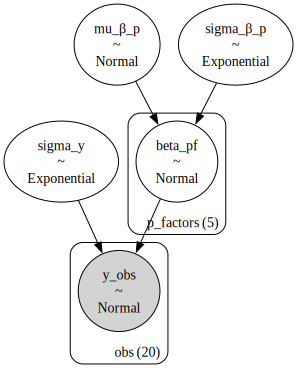

In [61]:
pm.model_to_graphviz(model_1)

In [62]:
az.summary(idata_m1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_pf[pf_0],0.489,0.031,0.429,0.547,0.001,0.000,3638.0,2238.0,1.0
beta_pf[pf_1],-0.160,0.028,-0.213,-0.107,0.000,0.000,4162.0,2868.0,1.0
beta_pf[pf_2],0.637,0.032,0.574,0.696,0.000,0.000,4413.0,2871.0,1.0
beta_pf[pf_3],1.521,0.029,1.468,1.575,0.000,0.000,3474.0,2442.0,1.0
beta_pf[pf_4],-0.290,0.021,-0.330,-0.250,0.000,0.000,4359.0,3013.0,1.0
mu_β_p,0.384,0.373,-0.359,1.053,0.007,0.005,3258.0,2641.0,1.0
sigma_y,0.104,0.020,0.069,0.141,0.000,0.000,2799.0,2382.0,1.0
sigma_β_p,0.875,0.344,0.395,1.481,0.007,0.005,3316.0,2702.0,1.0


In [63]:
D["beta"]

array([[ 0.49671415],
       [-0.1382643 ],
       [ 0.64768854],
       [ 1.52302986],
       [-0.23415337]])